In [1]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import random
import os
import datetime
import time
from efficientnet.tfkeras import EfficientNetB1, preprocess_input
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cv2

#from tensorflow.keras.utils import multi_gpu_model

from sklearn.model_selection import StratifiedKFold


## Data 준비

In [2]:
img_dir = '../datasets/emart24/cls_data/normal_aug/'
result = []
idx = 0

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]

for label in label_list:
    file_list = glob(os.path.join(img_dir,label,'*'))
    
    for file in file_list:
        result.append([idx, label, file])
        idx += 1
        
img_df = pd.DataFrame(result, columns=['idx','label','image_path'])

X = img_df[['idx','label']].values[:,0]
y = img_df[['idx','label']].values[:,1:]

img_df['fold'] = -1

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

for i, (trn_idx, vld_idx) in enumerate(skf.split(X,y)):
    img_df.loc[vld_idx, 'fold'] = i
    
img_df.to_csv('dataset.csv', index = False)

#img_df = pd.read_csv('../datasets/dataset.csv')

trn_fold = [i for i in range(10) if i not in [4]]
vld_fold = [4]

trn_idx = img_df.loc[img_df['fold'].isin(trn_fold)].index
vld_idx = img_df.loc[img_df['fold'].isin(vld_fold)].index

img_df

,idx,label,image_path,fold
0,0,fanta orange_pet,../datasets/emart24/cls_data/normal_aug/fanta ...,3
1,1,fanta orange_pet,../datasets/emart24/cls_data/normal_aug/fanta ...,0
2,2,fanta orange_pet,../datasets/emart24/cls_data/normal_aug/fanta ...,9
3,3,fanta orange_pet,../datasets/emart24/cls_data/normal_aug/fanta ...,0
4,4,fanta orange_pet,../datasets/emart24/cls_data/normal_aug/fanta ...,9
...,...,...,...,...
52495,52495,welchs_can,../datasets/emart24/cls_data/normal_aug/welchs...,4
52496,52496,welchs_can,../datasets/emart24/cls_data/normal_aug/welchs...,6
52497,52497,welchs_can,../datasets/emart24/cls_data/normal_aug/welchs...,5
52498,52498,welchs_can,../datasets/emart24/cls_data/normal_aug/welchs...,9


In [33]:
import random
random.randint(0,len(img_df['idx']))

42731

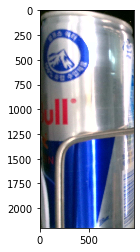

In [52]:
random
img = img_df['image_path'][random.randint(0,len(img_df['idx']))]
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

---

## Train 준비

In [14]:
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

AUTOTUNE = tf.data.experimental.AUTOTUNE
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


In [3]:
dataset_name = 'em24_normal_aug'
AUTOTUNE = tf.data.experimental.AUTOTUNE
#train_dataset_path = '../datasets/emart24/cls_train/train'
#valid_dataset_path = '../datasets/emart24/cls_train/validation'

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 5
#TRAIN_STEP_PER_EPOCH = tf.math.ceil(train_images_len / BATCH_SIZE).numpy()
#VALID_STEP_PER_EPOCH = tf.math.ceil(valid_images_len / BATCH_SIZE).numpy()

saved_path = '../em24_project/classification/model/'

time = datetime.datetime.now().strftime("%Y.%m.%d_%H:%M") + '_tf2'
weight_file_name = '{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint_path = saved_path + dataset_name + '/' + time + '/' + weight_file_name


if not(os.path.isdir(saved_path + dataset_name + '/' + time)):
    os.makedirs(os.path.join(saved_path + dataset_name + '/' + time))
else:
    pass

---

## 함수 선언

### 전처리 함수

In [4]:
def basic_processing(img_list, is_training):
    #img_path = pathlib.Path(img_path)

    #images = list(img_path.glob('*/*'))
    images = img_list
    images = [str(path) for path in images]
    len_images = len(images)

    if is_training:
        random.shuffle(images)

    #labels = sorted(item.name for item in img_path.glob('*/') if item.is_dir())
    labels = sorted(label_list)
    
    labels_len = len(labels)
    labels = dict((name, index) for index, name in enumerate(labels))
    labels = [labels[pathlib.Path(path).parent.name] for path in images]
    labels = tf.keras.utils.to_categorical(labels, num_classes=labels_len, dtype='float32')

    return images, labels, len_images, labels_len

def preprocess_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [224, 224])
    #image = keras.applications.xception.preprocess_input(image)  ## 수정해야함

    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  #  antialias = True 
    image = preprocess_input(image)
    return image

# 이미지 path -> tensor
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    
    return preprocess_image(image)

# tf dataset 만들기
def make_tf_dataset(images, labels):
    image_ds = tf.data.Dataset.from_tensor_slices(images)
    image_ds = image_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))

    image_label_ds = tf.data.Dataset.zip((image_ds, lable_ds))

    return image_label_ds


### Cutmix

In [5]:
def cutmix(images, labels, PROB = 0.3):
    imgs = []
    labs = []
    
    for i in range(BATCH_SIZE):
        APPLY = tf.cast(tf.random.uniform(()) <= PROB, tf.int32)
        idx = tf.random.uniform((), 0, BATCH_SIZE, tf.int32)
        
        W = IMG_SIZE
        H = IMG_SIZE
        lam = tf.random.uniform(())
        
        cut_ratio = tf.math.sqrt(1.-lam)
        cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
        cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY
        
        cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
        cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)
        
        xmin = tf.clip_by_value(cx - cut_w//2, 0, W)   # clip_by_value 값의 상한 하한 설정,
        ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
        xmax = tf.clip_by_value(cx + cut_w//2, 0, W)   # clip_by_value 값의 상한 하한 설정,
        ymax = tf.clip_by_value(cy + cut_h//2, 0, H)
        
        mid_left = images[i, ymin:ymax, :xmin, :]
        mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
        mid_right = images[i, ymin:ymax, xmax:, :]
        middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
        
        top = images[i, :ymin, :, :]
        bottom = images[i, ymax:, :, :]
        new_img = tf.concat([top, middle, bottom], axis = 0)
        imgs.append(new_img)
        
        alpha = tf.cast((cut_w*cut_h) / (W*H), tf.float32)
        label1 = labels[i]
        label2 = labels[idx]
        
        new_label = ((1-alpha) * label1 + alpha * label2)
        labs.append(new_label)
        
    new_imgs = tf.reshape(tf.stack(imgs), [-1, IMG_SIZE, IMG_SIZE, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, train_labels_len])
    
    return new_imgs, new_labs

In [15]:
trn_img_list = list(img_df.loc[img_df['idx'].isin(trn_idx)]['image_path'])
vld_img_list = list(img_df.loc[img_df['idx'].isin(vld_idx)]['image_path'])

train_images, train_labels, train_images_len, train_labels_len = basic_processing(trn_img_list, True)
valid_images, valid_labels, valid_images_len, valid_labels_len = basic_processing(vld_img_list, False)

In [16]:
TRAIN_STEP_PER_EPOCH = tf.math.ceil(train_images_len / BATCH_SIZE).numpy()
VALID_STEP_PER_EPOCH = tf.math.ceil(valid_images_len / BATCH_SIZE).numpy()

In [17]:
# 기본 Dataset 만들기

train_ds = make_tf_dataset(train_images, train_labels)
valid_ds = make_tf_dataset(valid_images, valid_labels)

train_ds = train_ds.repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # tf.data.experimental.AUTOTUNE
valid_ds = valid_ds.repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Cutmix 포함 Dataset 만들기

train_ds = make_tf_dataset(train_images, train_labels)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(cutmix).repeat()


valid_ds = make_tf_dataset(valid_images, valid_labels)
valid_ds = valid_ds.repeat().batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


W0617 08:37:45.964726 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


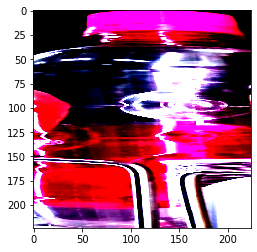

------------------------------------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.63145727 0.         0.         0.
 0.         0.36854273 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


W0617 08:37:47.167972 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


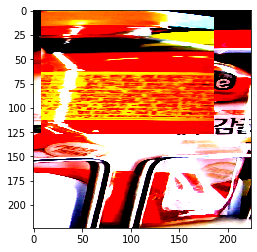

W0617 08:37:47.331240 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


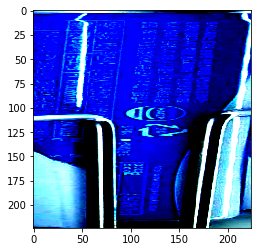

W0617 08:37:47.504578 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.36322147 0.         0.
 0.         0.         0.         0.         0.63677853 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


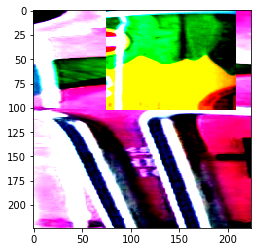

W0617 08:37:47.669005 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


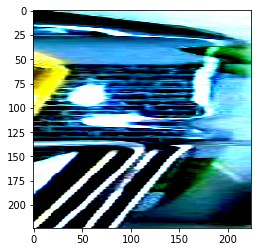

W0617 08:37:47.835662 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


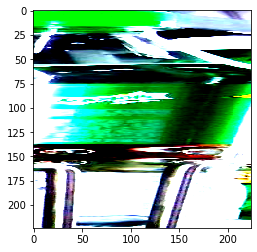

W0617 08:37:48.000915 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


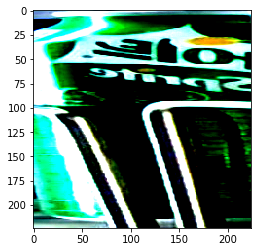

W0617 08:37:48.161958 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


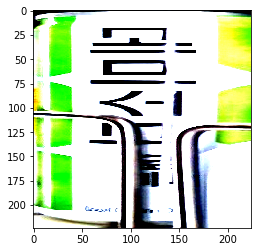

W0617 08:37:48.319888 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


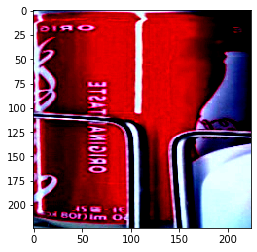

W0617 08:37:48.486663 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.40186542 0.         0.         0.         0.
 0.         0.         0.         0.5981346  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


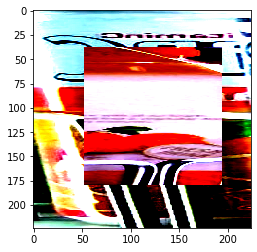

W0617 08:37:48.649674 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


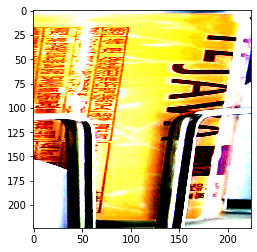

W0617 08:37:48.824452 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


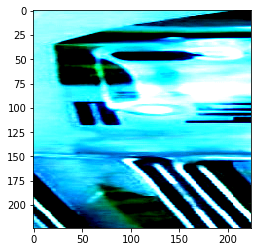

W0617 08:37:48.990443 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


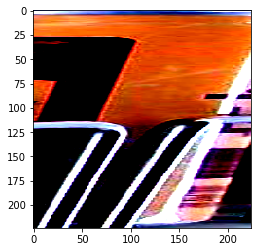

W0617 08:37:49.151262 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


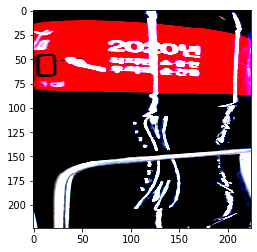

W0617 08:37:49.305172 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


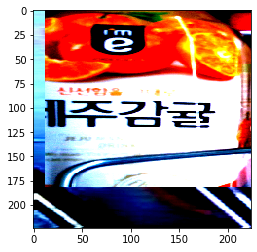

W0617 08:37:49.469708 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


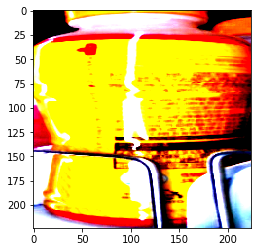

W0617 08:37:49.630032 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.29663584 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.70336413 0.         0.         0.         0.        ]


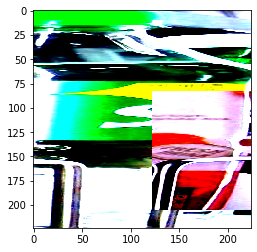

W0617 08:37:49.790442 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


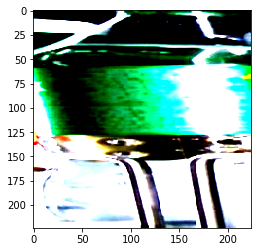

W0617 08:37:49.948429 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.0787428 0.        0.        0.9212572
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.       ]


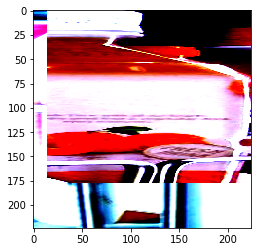

W0617 08:37:50.108305 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


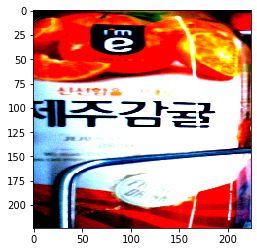

W0617 08:37:50.273962 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.18367347 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.8163265  0.         0.         0.        ]


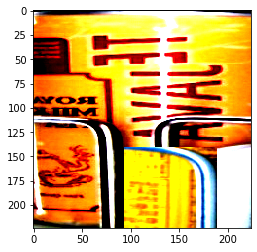

W0617 08:37:50.442617 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


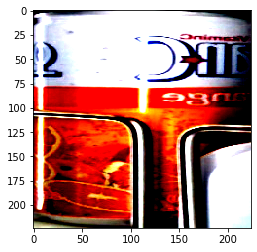

W0617 08:37:50.605082 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


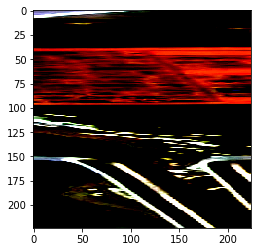

W0617 08:37:50.758812 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


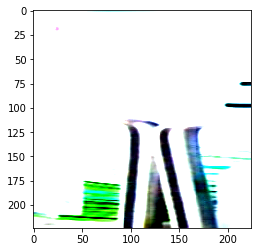

W0617 08:37:50.913719 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.5515784  0.         0.44842157
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


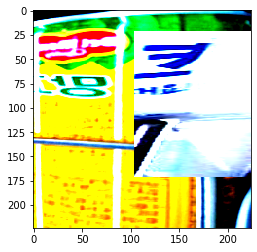

W0617 08:37:51.076149 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


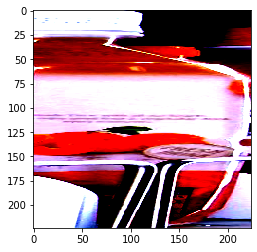

W0617 08:37:51.237161 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


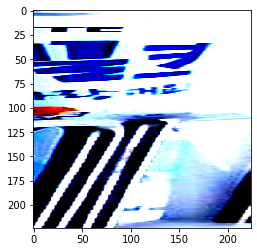

W0617 08:37:51.396774 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


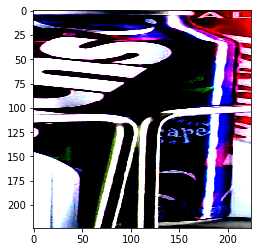

W0617 08:37:51.551878 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.        0.        0.        0.        0.        0.        0.
 0.        0.0787428 0.        0.        0.        0.        0.
 0.        0.9212572 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.       ]


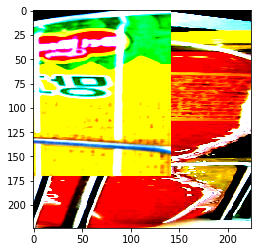

W0617 08:37:51.715250 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


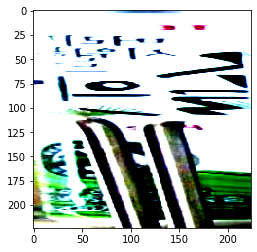

W0617 08:37:51.868998 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


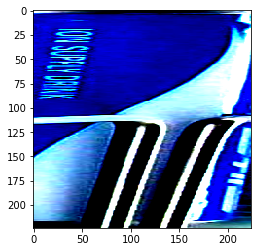

W0617 08:37:52.036726 140260412217152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.51660156 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.48339844 0.         0.         0.
 0.         0.         0.         0.         0.        ]


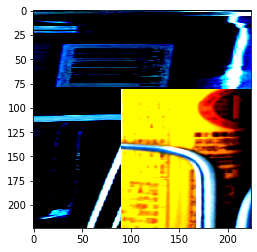

------------------------------------------------


In [12]:
for image, label in train_ds.take(1):
    for i in range(BATCH_SIZE):
        print(label[i].numpy())
        plt.imshow(image[i])
        plt.show()
        print('------------------------------------------------')

In [17]:
#tf.compat.v1.disable_eager_execution()
# single GPU

base_model = EfficientNetB1(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                            weights="imagenet",
                            include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(train_labels_len, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
#model = multi_gpu_model(model, gpus=3)



for layer in base_model.layers:
    layer.trainable = True


LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    if epoch < RAMUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMUP_EPOCH)
    return lr    


#optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(LR_INIT)


#model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              optimizer = optimizer,
              metrics=["accuracy"])


lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)
cb_early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#checkpoint_path = saved_path + dataset_name + '/' + time + '/' + weight_file_name
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     mode='auto')

In [18]:
## Multi gpu Training

def lr_schedule_fn(epoch):
    if epoch < RAMUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMUP_EPOCH)
    return lr  

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMUP_EPOCH = 4
EXP_DECAY = 0.9

optimizer = tf.keras.optimizers.Adam(LR_INIT)

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)
cb_early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#checkpoint_path = saved_path + dataset_name + '/' + time + '/' + weight_file_name
cb_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     mode='auto')


strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    base_model = EfficientNetB1(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                weights="imagenet",
                                include_top=False)
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(train_labels_len, activation="softmax")(avg)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = True

    #model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                  optimizer = optimizer,
                  metrics=["accuracy"])


In [19]:
#os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

history = model.fit(train_ds,
                    epochs=50,
                    steps_per_epoch=TRAIN_STEP_PER_EPOCH,
                    shuffle=False,
                    validation_data=valid_ds,
                    validation_steps=VALID_STEP_PER_EPOCH,
                    verbose=1,
                    callbacks=[lr_callback, cb_checkpointer, cb_early_stopper])  #cb_checkpointer, cb_early_stopper

model.save(saved_path + dataset_name  + '/' + dataset_name + '.h5')

Train for 1477.0 steps, validate for 165.0 steps
Epoch 1/50
1477/1477 [==============================] - 300s 203ms/step - loss: 3.5234 - accuracy: 0.0426 - val_loss: 3.3858 - val_accuracy: 0.1040
Epoch 2/50
1477/1477 [==============================] - 223s 151ms/step - loss: 1.1246 - accuracy: 0.9163 - val_loss: 0.7264 - val_accuracy: 0.9975
Epoch 3/50
1477/1477 [==============================] - 224s 152ms/step - loss: 0.7266 - accuracy: 0.9964 - val_loss: 0.6917 - val_accuracy: 0.9983
Epoch 4/50
1477/1477 [==============================] - 224s 151ms/step - loss: 0.6943 - accuracy: 0.9987 - val_loss: 0.6862 - val_accuracy: 0.9989
Epoch 5/50
1477/1477 [==============================] - 225s 152ms/step - loss: 0.6823 - accuracy: 0.9992 - val_loss: 0.6785 - val_accuracy: 0.9992
Epoch 6/50
1477/1477 [==============================] - 221s 150ms/step - loss: 0.6757 - accuracy: 0.9994 - val_loss: 0.6821 - val_accuracy: 0.9989
Epoch 7/50
1477/1477 [==============================] - 223s 15

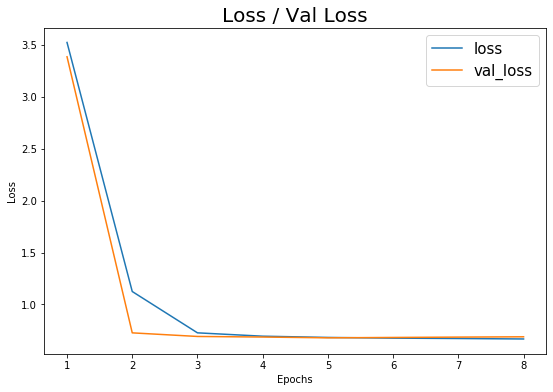

In [29]:
import numpy as np
epochs = 8

plt.figure(figsize=(9,6))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

In [27]:
history.history['loss']

[3.523448585414693,
 1.12463055172722,
 0.7265683985192306,
 0.6942715699315959,
 0.6822609419183466,
 0.6756864751846143,
 0.6720204464309346,
 0.6674940260423545]